## Análisis de la etapa de generación de medios

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  

## Armado del dataset

En este paso parsearemos los archivos para obtener estadísticas sobre el tiempo que tarda cada ejecución de una función, sobre la memoria usada, el uso de CPU (TODO). Con esto buscamos identificar:
- Qué funciones son las que consumen mayor cantidad de memoria
- Qué funciones son las que tienen un mayor tiempo de procesamiento
- Qué funciones son las que son invocadas una mayor cantidad de veces

Una vez identificados estos puntos de análisis podemos proponer soluciones para mejorar estas estadísticas.

In [5]:
def get_function_name(function_name):
    return function_name[10:].rsplit(".c")[0]

In [24]:
relations = {
    "Py_kgeneration": ['generate', 'fftma2'],
    "generate": ["gasdev"],
    "gasdev": ["ran2"],
    "fftma2": ["covariance", "fourt", "prebuild_gwn"]
}

In [7]:
def analyze(file_name):
    data = []

    with open(file_name) as log_file: 
        lines = log_file.readlines()
        print(len(lines))
        for line in lines:
            row = {}
            split_line = line.split()
            if "USED" not in split_line or "ELAPSED" not in split_line:
                continue
            idx_used_mem = split_line.index("USED") + 4
            idx_elapsed = split_line.index("ELAPSED") + 2
            
            function_name = get_function_name(split_line[2])
            used_virtual_mem = float(split_line[idx_used_mem])
            elapsed = float(split_line[idx_elapsed].rsplit(",")[0])

            # TODO: add CPU
            row["function"] = function_name
            row["memory"] = used_virtual_mem 
            row["time"] = elapsed
            data.append(row)
            
    df = pd.DataFrame(data)
    df_grouped = df.groupby(['function']).agg({'time': ['min', 'max', 'mean', 'sum', 'count'], 'memory': ['min', 'max', 'median']})
    return df_grouped.sort_values(by=('time', 'sum'), ascending=False)                

In [8]:
def plot_pie(df, function):
    plt.figure(dpi=125, figsize=(6, 6))
    labels = relations[function].copy()
    total = df.loc[function][('time', 'sum')]
    sizes = []
    explode = []

    rest = total

    for func in labels:
        func_duration = df.loc[func][('time', 'sum')]
        rest -= func_duration
        value = func_duration/ total
        sizes.append(value)
        explode.append(0 if value > 0.01 else 0.1)

    labels.append("other")
    sizes.append(rest/total)
    sizes = np.array(sizes)
    porcent = 100.*sizes/sizes.sum()
    explode.append(0 if rest/total > 0.01 else 0.1)

    plt.title(function)

    patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
    labels_formated = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, porcent)]

    sort_legend = True
    if sort_legend:
        patches, labels_formated, dummy =  zip(*sorted(zip(patches, labels_formated, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))

    plt.legend(patches, labels_formated, loc='upper left', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
    
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

def plot_analysis(df):
    for func in relations.keys():
        plot_pie(df, func)
    

## N = 8

In [9]:
df = analyze('log_8-aa')

1931


/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


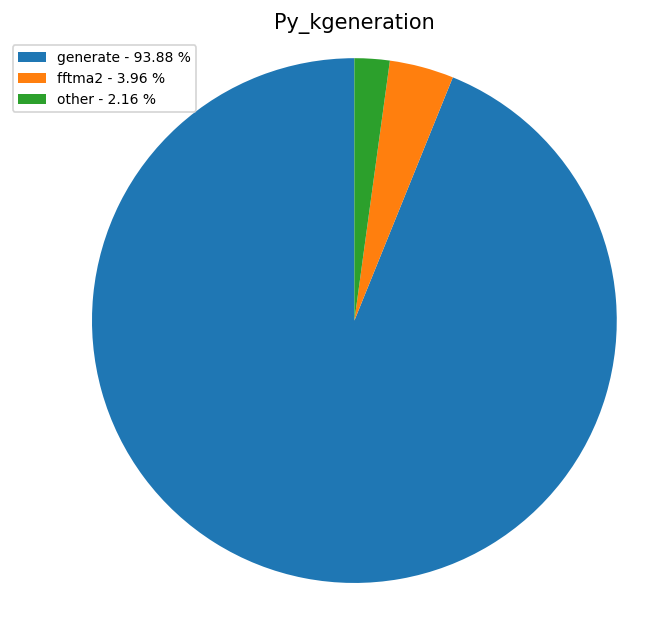

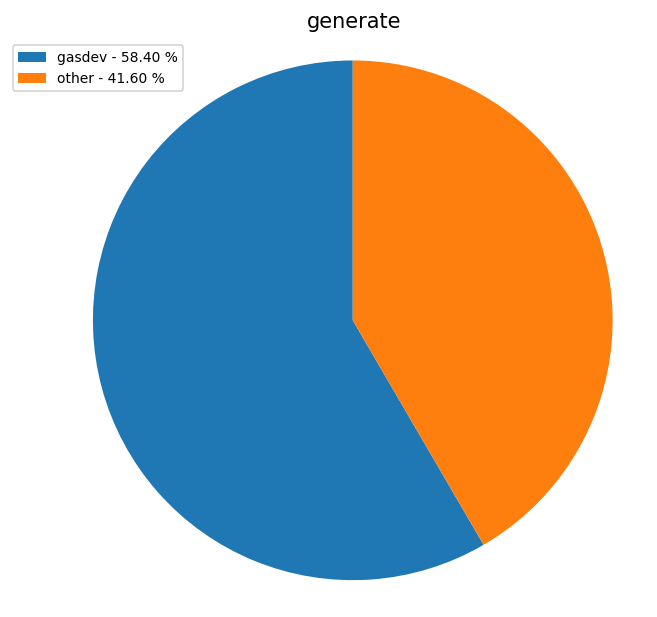

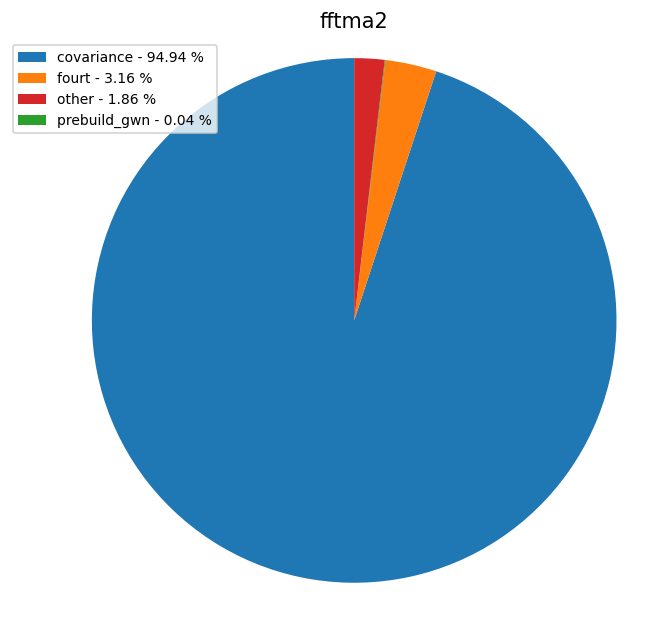

In [10]:
plot_analysis(df)

## N = 16

In [25]:
df = analyze('log_16-aa')

12945


In [27]:
df

time                                         memory       \
                     min       max          mean       sum count    min  max   
function                                                                       
Py_kgeneration  0.215496  0.215496  2.154960e-01  0.215496     1   -3.0 -3.0   
generate        0.189414  0.189414  1.894140e-01  0.189414     1   -3.0 -3.0   
gasdev          0.000000  0.003814  2.688184e-05  0.110108  4096   -4.0  0.2   
fftma2          0.023857  0.023857  2.385700e-02  0.023857     1    0.0  0.0   
covariance      0.022837  0.022837  2.283700e-02  0.022837     1    0.0  0.0   
ran2            0.000000  0.000007  5.074032e-07  0.002673  5268    0.0  0.2   
cov_value       0.000000  0.000018  5.033670e-07  0.001794  3564    0.0  0.0   
fourt           0.000233  0.000341  2.863333e-04  0.000859     3    0.0  0.0   
build_real      0.000054  0.000054  5.400000e-05  0.000054     1    0.0  0.0   
cgrid           0.000024  0.000024  2.400000e-05  0.000024     1    0.0  0.0   
prebuild_gwn    0.000018  0.000018  1.800000e-05  0.000018     1    0.0  0.0   
length          0.000004  0.000005  4.333333e-06  0.000013     3    0.0  0.0   
clean_real      0.000003  0.000003  3.000000e-06  0.000003     1    0.0  0.0   
maxfactor       0.000000  0.000001  6.666667e-07  0.000002     3    0.0  0.0   

                       
               median  
function               
Py_kgeneration   -3.0  
generate         -3.0  
gasdev            0.0  
fftma2            0.0  
covariance        0.0  
ran2              0.0  
cov_value         0.0  
fourt             0.0  
build_real        0.0  
cgrid             0.0  
prebuild_gwn      0.0  
length            0.0  
clean_real        0.0  
maxfactor         0.0

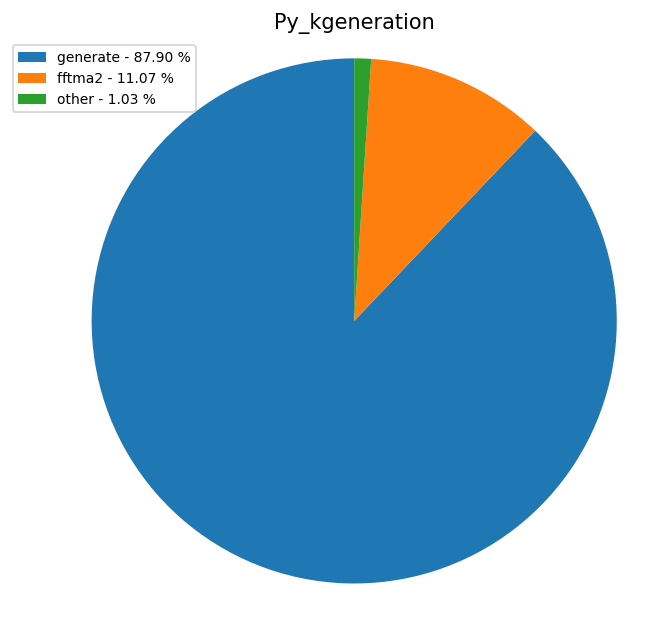

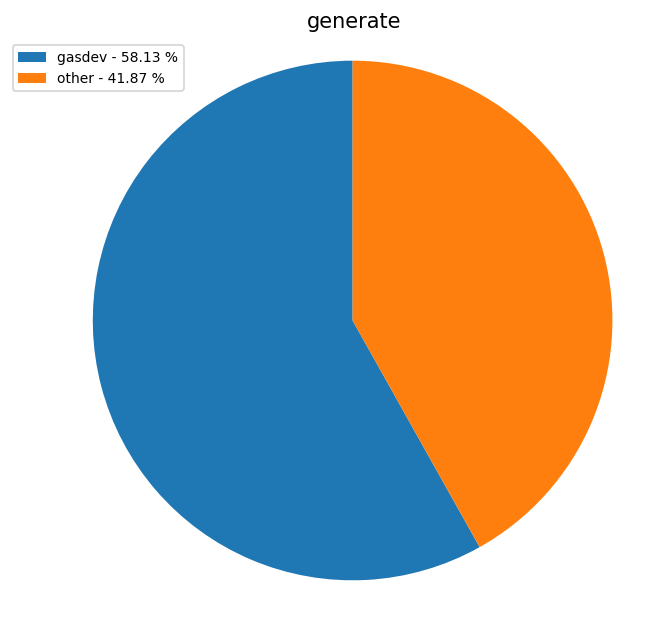

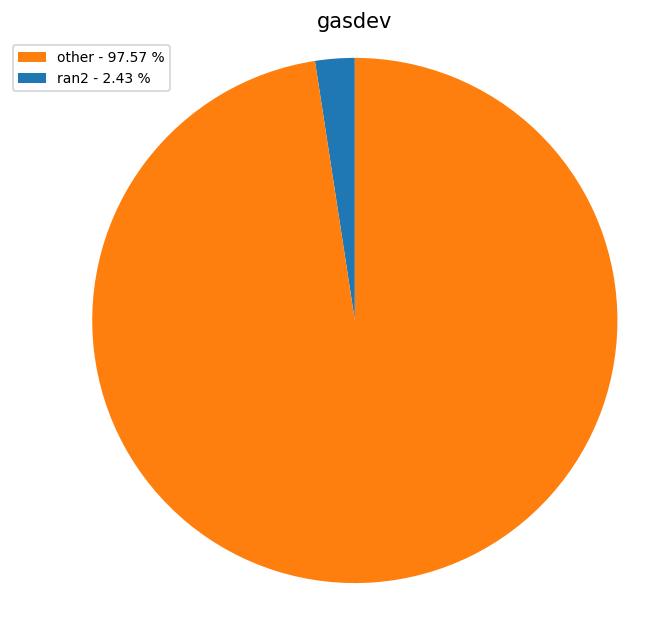

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


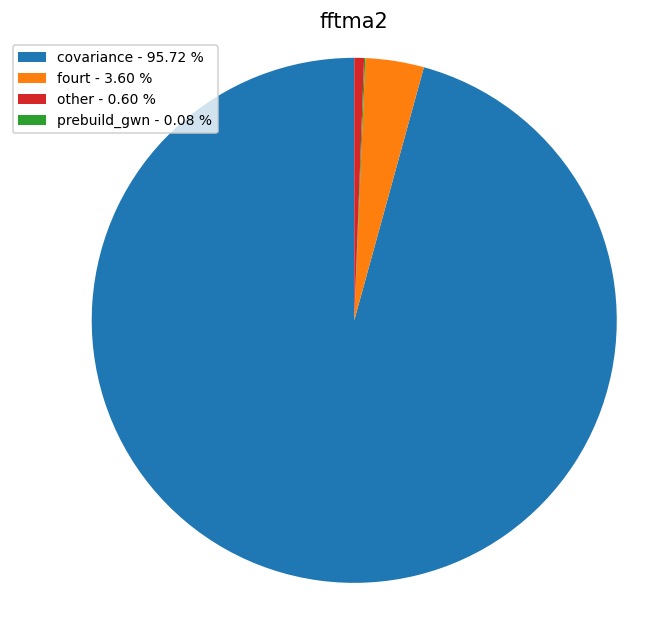

In [26]:
plot_analysis(df)

## N = 32

In [28]:
df = analyze('log_32-aa')

98963


In [29]:
df

time                                          memory       \
                     min       max          mean       sum  count    min  max   
function                                                                        
Py_kgeneration  0.788862  0.788862  7.888620e-01  0.788862      1    9.8  9.8   
generate        0.592958  0.592958  5.929580e-01  0.592958      1    3.6  3.6   
gasdev          0.000000  0.002927  1.034552e-05  0.339002  32768   -0.8  0.4   
fftma2          0.193739  0.193739  1.937390e-01  0.193739      1    6.2  6.2   
covariance      0.184742  0.184742  1.847420e-01  0.184742      1    5.0  5.0   
ran2            0.000000  0.000029  4.300876e-07  0.017871  41552   -0.2  0.2   
cov_value       0.000000  0.000022  6.040042e-07  0.014873  24624    0.0  0.4   
fourt           0.002029  0.003641  2.702000e-03  0.008106      3    0.0  0.2   
build_real      0.000441  0.000441  4.410000e-04  0.000441      1    0.5  0.5   
prebuild_gwn    0.000132  0.000132  1.320000e-04  0.000132      1    0.2  0.2   
clean_real      0.000076  0.000076  7.600000e-05  0.000076      1    0.0  0.0   
cgrid           0.000049  0.000049  4.900000e-05  0.000049      1    0.0  0.0   
length          0.000006  0.000015  1.066667e-05  0.000032      3    0.0  0.0   
maxfactor       0.000000  0.000001  6.000000e-07  0.000003      5    0.0  0.0   

                       
               median  
function               
Py_kgeneration    9.8  
generate          3.6  
gasdev            0.0  
fftma2            6.2  
covariance        5.0  
ran2              0.0  
cov_value         0.0  
fourt             0.2  
build_real        0.5  
prebuild_gwn      0.2  
clean_real        0.0  
cgrid             0.0  
length            0.0  
maxfactor         0.0

/home/oli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 


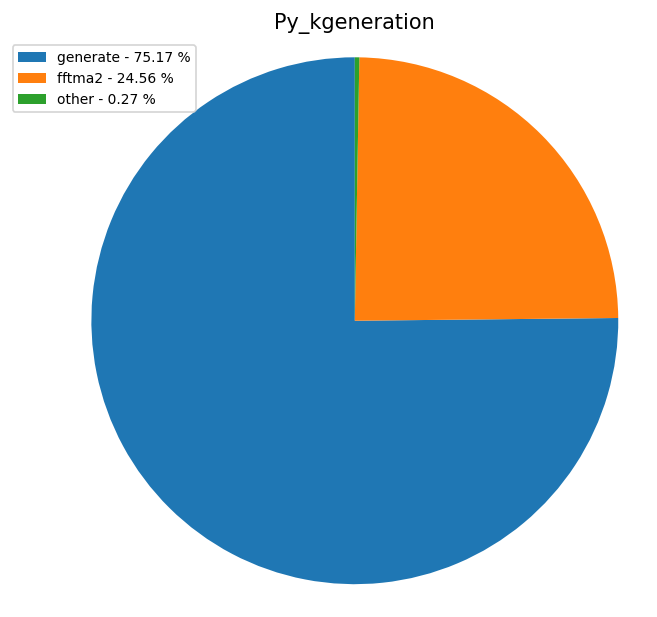

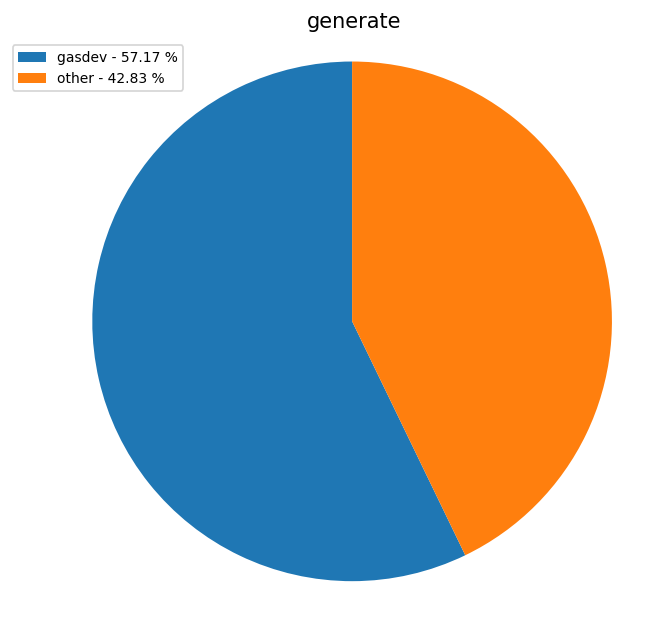

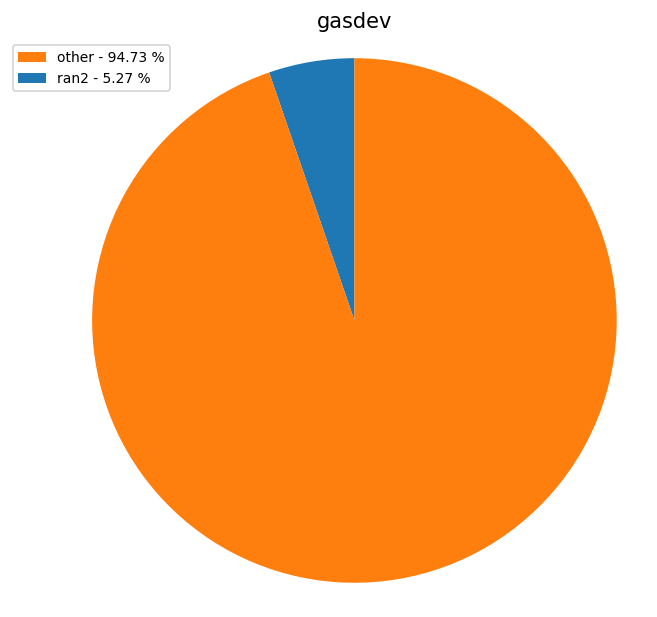

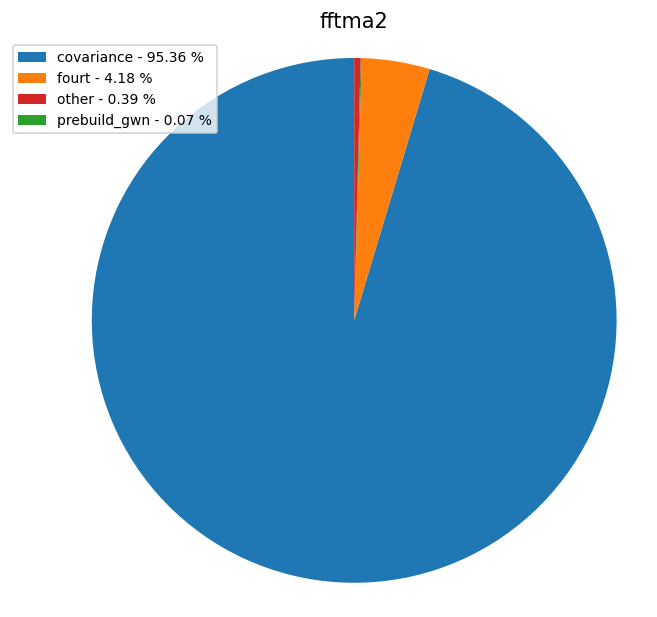

In [30]:
plot_analysis(df)

## N = 64

In [31]:
df = analyze('log_64-aa')

752428


In [32]:
df

time                                           memory  \
                     min       max          mean       sum   count    min   
function                                                                    
Py_kgeneration  4.949173  4.949173  4.949173e+00  4.949173       1  120.8   
generate        3.664372  3.664372  3.664372e+00  3.664372       1   77.4   
gasdev          0.000000  0.000135  8.024132e-06  2.103478  262144   -1.8   
fftma2          1.284480  1.284480  1.284480e+00  1.284480       1   45.5   
covariance      1.196127  1.196127  1.196127e+00  1.196127       1   39.1   
ran2            0.000000  0.000056  3.717559e-07  0.123962  333450   -0.2   
cov_value       0.000000  0.000029  5.676589e-07  0.089018  156816   -0.2   
fourt           0.021057  0.040839  2.775567e-02  0.083267       3    0.0   
build_real      0.002964  0.002964  2.964000e-03  0.002964       1    0.0   
prebuild_gwn    0.000825  0.000825  8.250000e-04  0.000825       1    2.5   
clean_real      0.000608  0.000608  6.080000e-04  0.000608       1    0.9   
cgrid           0.000055  0.000055  5.500000e-05  0.000055       1    0.0   
length          0.000008  0.000016  1.066667e-05  0.000032       3    0.0   
maxfactor       0.000000  0.000001  5.000000e-07  0.000002       4    0.0   

                              
                  max median  
function                      
Py_kgeneration  120.8  120.8  
generate         77.4   77.4  
gasdev            0.5    0.0  
fftma2           45.5   45.5  
covariance       39.1   39.1  
ran2              0.4    0.0  
cov_value         0.3    0.0  
fourt             3.9    0.5  
build_real        0.0    0.0  
prebuild_gwn      2.5    2.5  
clean_real        0.9    0.9  
cgrid             0.0    0.0  
length            0.0    0.0  
maxfactor         0.0    0.0

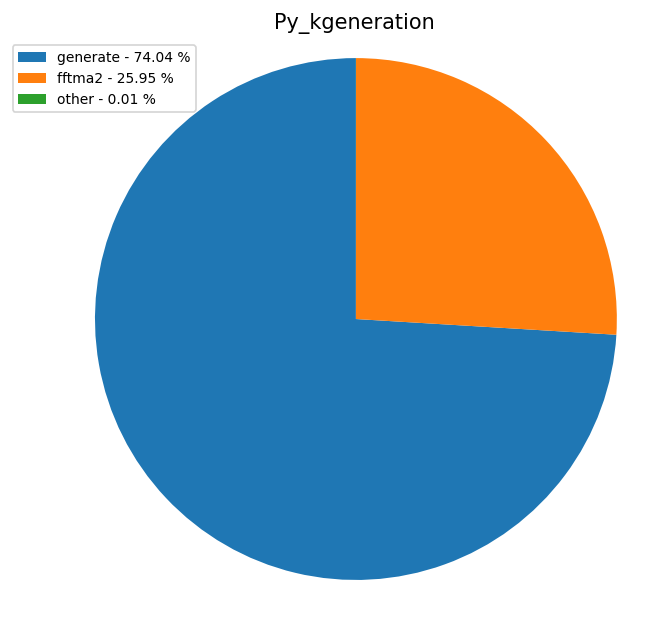

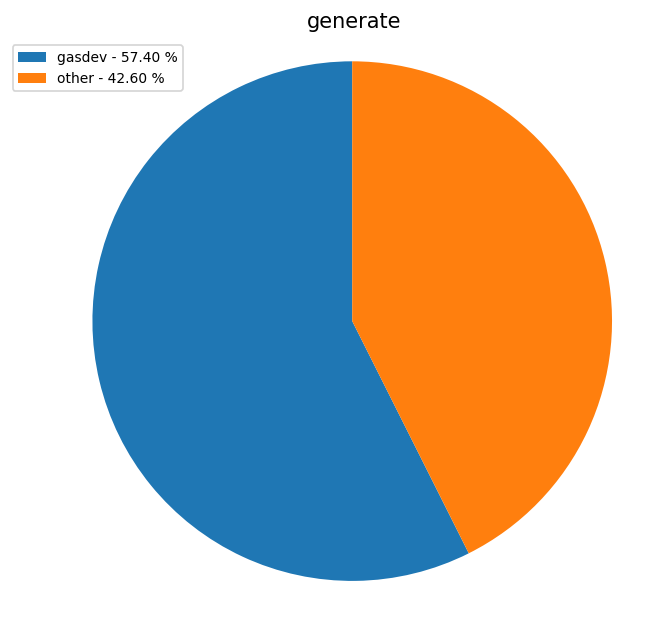

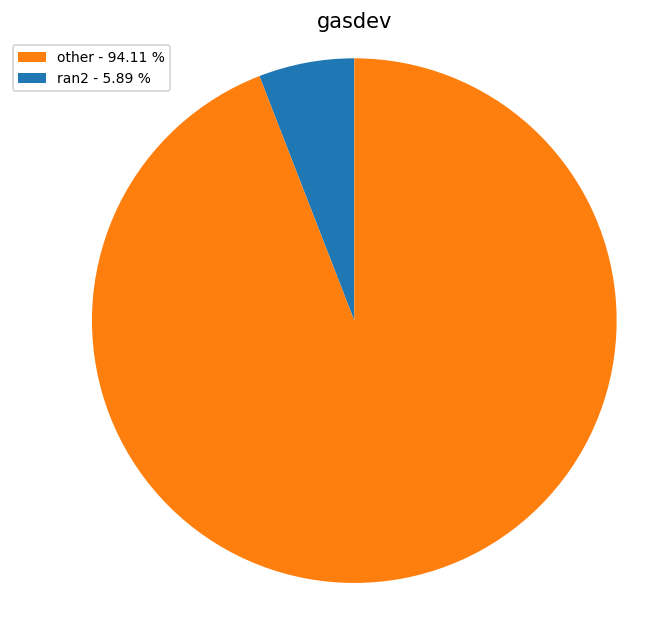

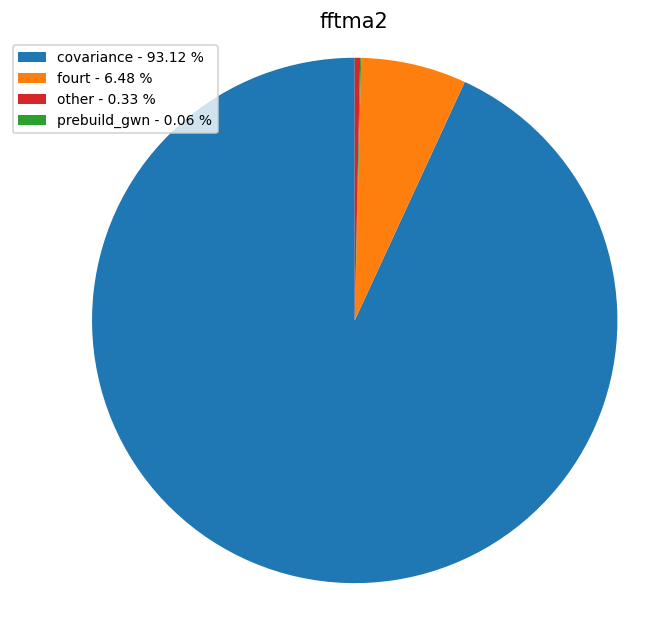

In [33]:
plot_analysis(df)

## N = 128

In [ ]:
df = analyze('log_128-aa')

5897863


In [ ]:
df

In [ ]:
plot_analysis(df)

## N = 256

In [ ]:
df = []